<a href="https://colab.research.google.com/github/robertmkjeffrey/anomoly-detection-site-19/blob/main/tests/compactness_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.utils.data as torchdata
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as tf

from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

anomoly_label = 9
num_normal_classes = 9

Using cpu device


In [2]:
raw_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

raw_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

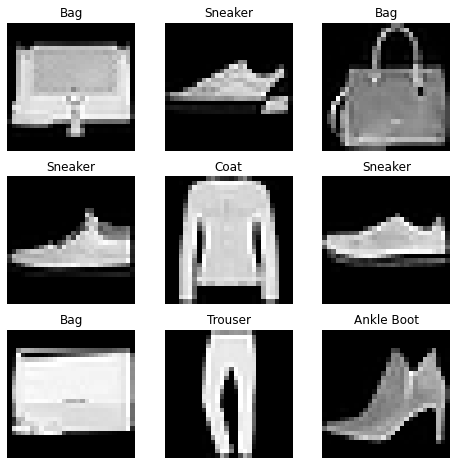

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

def show_data_sample(dataset):
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

def show_data_sample_iter(data_iterable):
    show_data_sample(next(iter(data_iterable)))

show_data_sample(raw_training_data)

In [4]:
# Define datasets for anomolous and normal data.
anomolous_train = raw_training_data.targets == anomoly_label
train_data_normal = torchdata.Subset(
    raw_training_data,
    (~anomolous_train).nonzero().reshape(-1))

train_data_anomolous = torchdata.Subset(
    raw_training_data,
    anomolous_train.nonzero().reshape(-1))

anomolous_test = raw_test_data.targets == anomoly_label
test_data_normal = torchdata.Subset(
    raw_test_data,
    (~anomolous_test).nonzero().reshape(-1))

test_data_anomolous = torchdata.Subset(
    raw_test_data,
    anomolous_test.nonzero().reshape(-1))

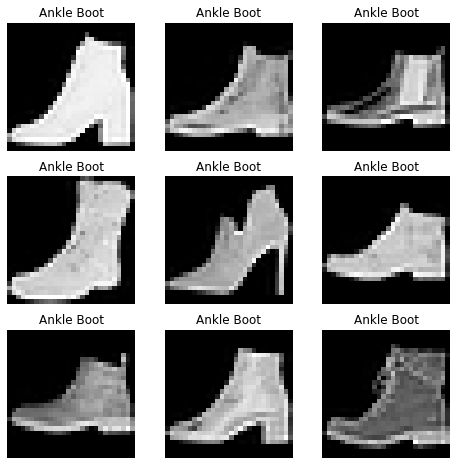

In [5]:
show_data_sample(train_data_anomolous)

In [6]:
class FCModel(torch.nn.Module):

  input_size = 28*28

  def __init__(self):
    super(FCModel, self).__init__()

    self.epochs = 0
    self.training_log = []

    self.flatten = torch.nn.Flatten()
    self.layer1 = torch.nn.Linear(self.input_size, 20)
    self.layer2 = torch.nn.Linear(20, num_normal_classes)

  def hidden(self, x):
    x = self.flatten(x)
    h = self.layer1(x)
    h = tf.relu(h)
    return h

  def _forward(self, x):
    h = self.hidden(x)
    out = self.layer2(h)
    return h, out

  def forward(self, x):
    return self._forward(x)[1]

model = FCModel().to(device)
print(model)

FCModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=9, bias=True)
)


In [7]:
def CompactnessLoss(hidden_batch):
  """Compactness loss, as defined in PANDA.

  $$L_compactness = \sum_{x \in D_{train} \|\phi(x) - c\|^2}$$

  Where c is the mean \phi(x) over the dataset.

  We approximate that with the batch.
  """
  batch_mean = torch.mean(hidden_batch, dim=0)
  return torch.linalg.norm(hidden_batch - batch_mean) ** 2

In [8]:
learning_rate = 0.5e-2
batch_size = 128

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_dataloader_normal = torchdata.DataLoader(train_data_normal, batch_size=64, shuffle=True)
test_dataloader_normal = torchdata.DataLoader(test_data_normal, batch_size=64, shuffle=True)

def train_loop(data_loader, model, loss_function, optimizer):
    loss_log = []
    size = len(data_loader.dataset)
    for batch, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        h, pred = model._forward(X)
        compactness_loss = CompactnessLoss(h)
        prediction_loss = loss_function(pred, y)

        loss = compactness_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return {"loss": loss_log}

def test_loop(data_loader, model, loss_function, run_type):
  size = len(data_loader.dataset)
  num_batches = len(data_loader)
  test_loss, correct = 0, 0

  with torch.no_grad():
      for X, y in data_loader:
          X = X.to(device)
          y = y.to(device)
          h, pred = model._forward(X)

          compactness_loss = CompactnessLoss(h)
          prediction_loss = loss_function(pred, y)
          loss = compactness_loss
          test_loss += loss.item()
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f"{run_type} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return {"loss": test_loss, "accuracy" : correct}

In [9]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {model.epochs + 1}\n-------------------------------")
    train_loop(train_dataloader_normal, model, loss_function, optimizer)
    train_log = test_loop(train_dataloader_normal, model, loss_function, "Train")
    test_log = test_loop(test_dataloader_normal, model, loss_function, "Test")

    # Record metrics for the current epoch
    model.epochs += 1
    model.training_log.append((train_log, test_log))

    if (model.epochs + 1) % 5 == 0:
      print(f"Saving model at epoch {model.epochs+1}")
      PATH = f"model_epoch_{model.epochs+1}.pt"
      torch.save({
            'epoch': model.epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)
print("Done!")

Epoch 1
-------------------------------
loss: 17.829590  [    0/54000]
loss: 0.000000  [ 6400/54000]
loss: 0.000000  [12800/54000]
loss: 0.000074  [19200/54000]
loss: 0.000013  [25600/54000]
loss: 0.001399  [32000/54000]
loss: 0.000000  [38400/54000]
loss: 0.000020  [44800/54000]
loss: 0.000000  [51200/54000]
Train Error: 
 Accuracy: 11.1%, Avg loss: 0.000028 

Test Error: 
 Accuracy: 11.1%, Avg loss: 0.000078 

Epoch 2
-------------------------------
loss: 0.000000  [    0/54000]
loss: 0.000000  [ 6400/54000]
loss: 0.000000  [12800/54000]
loss: 0.000000  [19200/54000]
loss: 0.000000  [25600/54000]
loss: 0.000000  [32000/54000]
loss: 0.000000  [38400/54000]
loss: 0.000000  [44800/54000]
loss: 0.000000  [51200/54000]
Train Error: 
 Accuracy: 11.1%, Avg loss: 0.000012 

Test Error: 
 Accuracy: 11.1%, Avg loss: 0.000048 

Done!


In [10]:
test_batch = next(iter(test_dataloader_normal))[0]
test_hiddens = model._forward(test_batch)[0]

In [11]:
test_hiddens

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReluBackward0>)

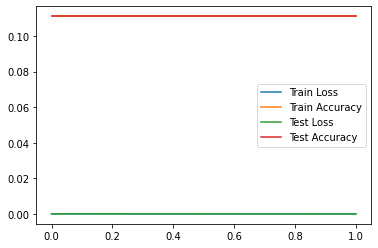

In [12]:
epoch = range(len(model.training_log))
train_loss = [np.mean(x[0]["loss"]) for x in model.training_log]
train_accuracy = [x[0]["accuracy"] for x in model.training_log]
test_loss = [x[1]["loss"] for x in model.training_log]
test_accuracy = [x[1]["accuracy"] for x in model.training_log]

plt.plot(epoch, train_loss, label = "Train Loss")
plt.plot(epoch, train_accuracy, label="Train Accuracy")
plt.plot(epoch, test_loss, label = "Test Loss")
plt.plot(epoch, test_accuracy, label="Test Accuracy")
plt.legend()